In [68]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import os


In [69]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data
file_path = "S&P_500_Historical_Data.csv"  # Replace with the actual file path
df = pd.read_csv(file_path)

# Convert the "Date" column to datetime
df["Date"] = pd.to_datetime(df["Date"], format='%m/%d/%Y')

# Sort the data by date in ascending order
df = df.sort_values(by="Date")

# Remove commas in the "Price" column and convert it to numeric
df["Price"] = df["Price"].str.replace(",", "").astype(float)

# Get the earliest and latest dates
earliest_date = df["Date"].min()
latest_date = df["Date"].max()

print("Earliest Date:", earliest_date)
print("Latest Date:", latest_date)


Earliest Date: 2006-01-03 00:00:00
Latest Date: 2024-12-17 00:00:00


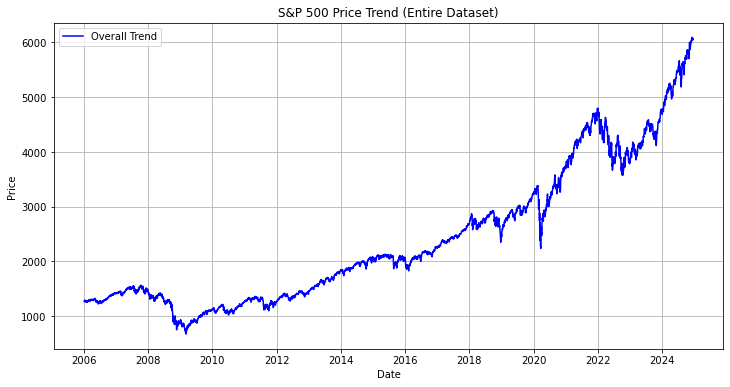

In [70]:
# Plot the trend for the entire dataset
plt.figure(figsize=(12, 6))
plt.plot(df["Date"], df["Price"], label="Overall Trend", color="blue")
plt.title("S&P 500 Price Trend (Entire Dataset)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid()
plt.show()


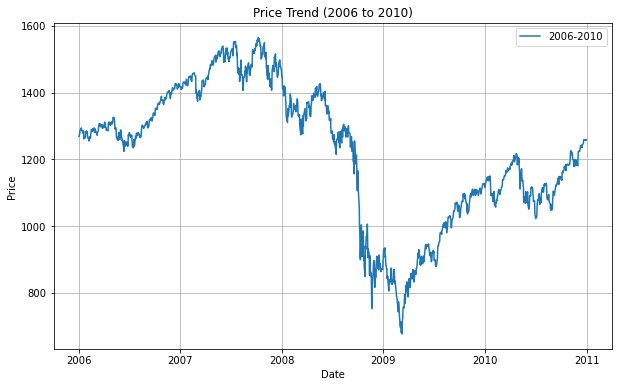

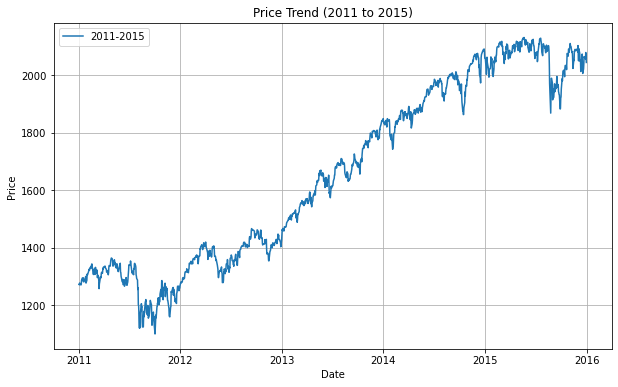

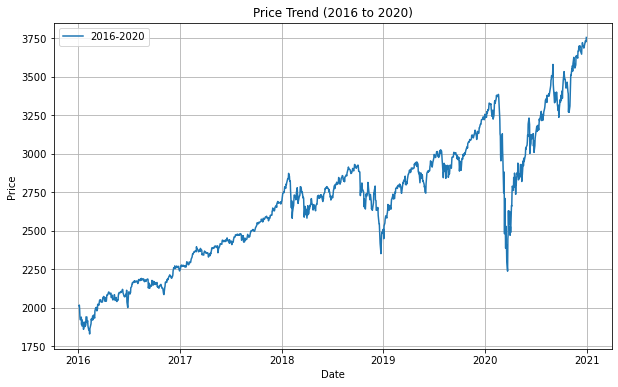

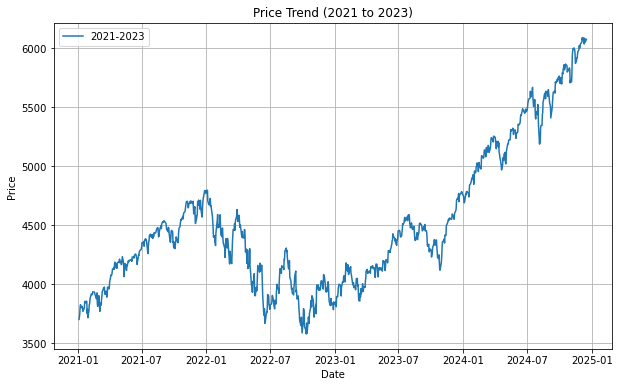

In [71]:
# Generate 5-year intervals
interval_start = earliest_date
intervals = []
while interval_start < latest_date:
    interval_end = interval_start + pd.DateOffset(years=5)
    intervals.append((interval_start, min(interval_end, latest_date)))
    interval_start = interval_end

# Plot data for each interval
for start, end in intervals:
    interval_data = df[(df["Date"] >= start) & (df["Date"] < end)]
    plt.figure(figsize=(10, 6))
    plt.plot(interval_data["Date"], interval_data["Price"], label=f"{start.year}-{end.year-1}")
    plt.title(f"Price Trend ({start.year} to {end.year-1})")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.grid()
    plt.show()


In [72]:
if "Vol." in df.columns and "Change %" in df.columns:    
    df = df.drop(columns=["Vol.", "Change %"])

In [73]:
print(df.dtypes)

Date     datetime64[ns]
Price           float64
Open             object
High             object
Low              object
dtype: object


In [74]:
# Convert object columns to float
for col in ['Open', 'High', 'Low']:
    df[col] = pd.to_numeric(df[col].str.replace(",", ""), errors='coerce')

print(df.dtypes)

Date     datetime64[ns]
Price           float64
Open            float64
High            float64
Low             float64
dtype: object


In [75]:
if "Target" not in df.columns:
    df["Target"] = (df["Price"].shift(-1) > df["Price"]).astype(int)


In [76]:
df = df.dropna()

## CREATING THE NN MODEL

In [77]:
dates = df["Date"]
X = df.drop(columns=["Date", "Target"])
y = df["Target"]
X['Days_of_week'] = dates.dt.dayofweek
X['Month'] = dates.dt.month
X['Year'] = dates.dt.year


In [78]:
X = pd.get_dummies(X, columns=['Days_of_week', 'Month', 'Year'], drop_first=True)

In [79]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [80]:
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print("Training set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)
print("Test set shape:", X_test.shape)

Training set shape: (3817, 37)
Validation set shape: (477, 37)
Test set shape: (478, 37)


In [81]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [82]:
# Convert datasets to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

# Create DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [83]:
# Define the LSTM-based model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout_rate):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_rate)
        self.fc = nn.Linear(hidden_size, 1)  # Output layer for binary classification
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        # LSTM expects input of shape (batch_size, sequence_length, input_size)
        out, (hn, cn) = self.lstm(x)
        # Use the output of the last time step
        out = out[:, -1, :]  # Shape: (batch_size, hidden_size)
        out = self.fc(out)  # Shape: (batch_size, 1)
        out = self.sigmoid(out)
        return out

# Hyperparameters
hidden_size = 64
num_layers = 2
dropout_rate = 0.3

# Initialize the LSTM model
model = LSTMModel(input_size=X_train.shape[1], hidden_size=hidden_size, num_layers=num_layers, dropout_rate=dropout_rate)

# Define loss and optimizer
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop (similar to before)
num_epochs = 50
patience = 5  # Early stopping patience
best_val_loss = float('inf')
early_stop_counter = 0

train_losses, val_losses = [], []

if not os.path.exists("./models/best_lstm_model.pth"):
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for X_batch, y_batch in train_loader:
            # Reshape input for LSTM: (batch_size, sequence_length, input_size)
            X_batch = X_batch.unsqueeze(1)
            y_batch = y_batch.unsqueeze(1)  # Match output shape
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        train_losses.append(train_loss / len(train_loader))
        
        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch = X_batch.unsqueeze(1)
                y_batch = y_batch.unsqueeze(1)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                val_loss += loss.item()
        
        val_losses.append(val_loss / len(val_loader))
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")
        
        # Early stopping
        if val_losses[-1] < best_val_loss:
            best_val_loss = val_losses[-1]
            torch.save(model.state_dict(), "./models/best_lstm_model.pth")
            early_stop_counter = 0
        else:
            early_stop_counter += 1
            if early_stop_counter >= patience:
                print("Early stopping triggered.")
                break

# Load the best model and evaluate
model.load_state_dict(torch.load("./models/best_lstm_model.pth"))

# Evaluate on test data
model.eval()
y_pred = []
y_true = []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.unsqueeze(1)  # Reshape for LSTM
        outputs = model(X_batch)
        y_pred.extend(outputs.squeeze().numpy())
        y_true.extend(y_batch.numpy())

# Convert predictions to binary
y_pred_binary = [1 if pred > 0.5 else 0 for pred in y_pred]

# Accuracy
test_accuracy = accuracy_score(y_true, y_pred_binary)
print(f"Test Accuracy: {test_accuracy:.2f}")


Test Accuracy: 0.53


C:\Users\ROG\AppData\Local\Temp/ipykernel_19356/378853193.py:81: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("./models/best_lstm_model.pth